In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
df= pd.read_csv("final_df.csv")

In [3]:
df.head()

,polarity,words,Fri,Mon,Sat,Sun,Thu,Tue,Wed,h_00,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,0,"{'awww': 1, 'bummer': 1, 'shoulda': 1, 'david'...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,"{'upset': 1, 'notupdate': 1, 'facebook': 1, 't...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,"{'dive': 1, 'many': 1, 'time': 1, 'ball': 1, '...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,"{'whole': 1, 'body': 1, 'feel': 1, 'itchy': 1,...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,"{'mad': 1, 'notsee': 1}",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# Renaming all features to be of capital letters or containing number like h_00
# That will help us when converting the dict of words to frequency encoding in order not to have any word
# that already existed in the previous features. (We are sure as our words are small and don't contain numbers)
df.rename(columns={"polarity":"Polarity", "words":"Words"}, inplace=True)

In [5]:
# Using 8 bits instead of 64 bits
for col in df.columns:
    if col!='Words':
        df[col] = df[col].astype(np.int8)

In [6]:
# Converting string dictionary to python dictionary
import ast

df['Words'] = df['Words'].apply(lambda x: ast.literal_eval(x))

## Word2Vec

In [7]:
sample = df.sample(frac = 0.10, random_state=1)
sample.reset_index(drop=True, inplace=True)

In [8]:
sample.head()

,Polarity,Words,Fri,Mon,Sat,Sun,Thu,Tue,Wed,h_00,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,0,"{'omg': 1, 'one': 1, 'year': 1, 'work': 1, 'pe...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"{'meantime': 1, 'revision': 1, 'whilst': 1, 'l...",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,"{'pierce': 1, 'fail': 1, 'time': 1, 'fuck': 1}",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,"{'win': 1, 'award': 1, 'play': 1, 'tennis': 1}",0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,"{'want': 1, 'back': 1, 'bed': 1, 'notwait': 1,...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
import gensim.downloader as api

#      'glove-twitter-100':{'num_records': 1193514,
#      'file_size': 795373100,
#      'base_dataset': 'Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)',
#      'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-twitter-200/__init__.py',
#      'license': 'http://opendatacommons.org/licenses/pddl/',
#      'parameters': {'dimension': 200},
#      'description': 'Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/).',
#      'preprocessing': 'Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-twitter-200.txt`.',
#      'read_more': ['https://nlp.stanford.edu/projects/glove/',
#       'https://nlp.stanford.edu/pubs/glove.pdf'],
#      'checksum': 'e52e8392d1860b95d5308a525817d8f9',
#      'file_name': 'glove-twitter-200.gz',
#      'parts': 1}

wv = api.load('glove-twitter-200')

In [10]:
def wvContains(word):
    try:
        x = wv[word]
        return True
    except KeyError:
        return False

In [11]:
def doc2vec(x): 
    word_dict = x
    sv = np.zeros(200)
    s_freq = 0
    for word, freq in word_dict.items():
        if wvContains(word):
            sv += (wv[word] * freq)
            s_freq += freq
        else:
            # If it doesn't contain the word, then it can be either our bigram that begins with not
            if word[0:3] == 'not':
                sv += (wv[word[0:3]] + wv[word[3:]]) * freq
                s_freq += 2 * freq
            else:
                # Or it can be a word like
                # ummmm, loveee, omggg, ahhhhhhhhhhh
                # so, we remove the latest characters until wv recognizes it or we only have two characters left
                end = len(word)-1
                while (end > 1) and (not wvContains(word[0:end])):
                    end -= 1
                
                if wvContains(word[0:end]):
                    sv += (wv[word[0:end]] * freq)
                    s_freq += freq
    if s_freq != 0:
        return (1/s_freq) * sv
    else:
        return np.zeros(200)

In [12]:
sample['Vec'] = sample['Words'].apply(doc2vec)

In [13]:
columns_names = []
for i in range(200):
    columns_names.append('v_' + str(i))

In [14]:
ll = []
for i in range(len(sample)):
    ll.append(sample['Vec'][i])

In [15]:
dd = pd.DataFrame(ll, columns=columns_names)
dd.head()

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_190,v_191,v_192,v_193,v_194,v_195,v_196,v_197,v_198,v_199
0,0.093035,0.106287,0.059583,0.008553,-0.137730,0.054501,0.576705,0.102059,-0.083966,0.036883,...,-0.086562,0.094185,0.107950,-0.101095,-0.156658,-0.160173,-0.014545,0.080321,-0.062269,0.172431
1,0.165076,-0.174803,-0.033236,0.005544,-0.369112,0.154184,0.457701,-0.125422,0.021626,-0.228392,...,-0.179364,0.008583,0.187346,0.088731,0.123860,-0.214567,-0.082599,0.101344,-0.050733,0.033317
2,0.087882,-0.143381,0.042825,-0.336283,-0.345347,0.348151,0.635898,0.113026,-0.002637,0.319735,...,-0.221135,0.029440,-0.040809,-0.117935,0.121992,-0.339450,-0.010807,0.143783,-0.122472,0.028752
3,0.051195,0.546090,0.198963,-0.471660,0.216742,-0.019456,0.089722,0.456894,0.182935,-0.027775,...,-0.215262,-0.166991,0.094304,-0.392611,-0.003040,-0.137047,0.454745,0.136449,-0.238210,0.309903
4,0.202791,-0.069943,-0.160822,0.018996,-0.213993,0.137565,0.921150,0.119451,0.047930,0.147317,...,-0.155972,-0.273515,-0.090795,-0.128035,0.070136,-0.310525,0.239245,0.031857,0.123825,0.172223


In [16]:
sample = sample.join(dd)
sample.drop(columns = ['Words', 'Vec'], inplace = True)

In [17]:
sample.head()

,Polarity,Fri,Mon,Sat,Sun,Thu,Tue,Wed,h_00,h_01,...,v_190,v_191,v_192,v_193,v_194,v_195,v_196,v_197,v_198,v_199
0,0,1,0,0,0,0,0,0,0,0,...,-0.086562,0.094185,0.107950,-0.101095,-0.156658,-0.160173,-0.014545,0.080321,-0.062269,0.172431
1,1,0,0,0,0,0,1,0,0,0,...,-0.179364,0.008583,0.187346,0.088731,0.123860,-0.214567,-0.082599,0.101344,-0.050733,0.033317
2,1,0,0,0,0,0,1,0,0,0,...,-0.221135,0.029440,-0.040809,-0.117935,0.121992,-0.339450,-0.010807,0.143783,-0.122472,0.028752
3,1,0,0,0,1,0,0,0,0,0,...,-0.215262,-0.166991,0.094304,-0.392611,-0.003040,-0.137047,0.454745,0.136449,-0.238210,0.309903
4,0,0,0,1,0,0,0,0,0,0,...,-0.155972,-0.273515,-0.090795,-0.128035,0.070136,-0.310525,0.239245,0.031857,0.123825,0.172223


In [18]:
X = sample.iloc[:,1:]
y = sample.iloc[:,0]

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_test

,Fri,Mon,Sat,Sun,Thu,Tue,Wed,h_00,h_01,h_02,...,v_190,v_191,v_192,v_193,v_194,v_195,v_196,v_197,v_198,v_199
101847,0,0,0,1,0,0,0,0,0,0,...,0.327060,-0.181368,0.683687,-0.279156,0.301244,0.187723,-0.138307,0.586503,-0.334270,0.073890
68123,1,0,0,0,0,0,0,0,0,0,...,-0.120148,-0.183074,-0.029009,-0.225073,0.036126,-0.163332,0.064432,0.036224,-0.180428,0.120660
130461,0,0,0,0,1,0,0,0,0,0,...,0.229881,0.077091,0.237163,0.142399,0.130920,0.012310,0.125375,0.018377,-0.078055,-0.062644
97279,0,0,0,1,0,0,0,0,1,0,...,-0.174100,-0.121538,0.379072,-0.151055,0.101991,-0.035207,0.112669,0.293698,0.007507,0.082987
54276,1,0,0,0,0,0,0,0,0,0,...,-0.149364,-0.055824,0.320718,-0.360748,0.061924,-0.425259,0.013437,0.100520,0.011100,0.190528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91409,1,0,0,0,0,0,0,0,0,0,...,0.010434,0.126109,-0.147199,-0.337774,-0.102184,-0.145010,-0.020840,-0.067004,0.300600,0.078891
52102,1,0,0,0,0,0,0,0,0,0,...,-0.056790,0.049989,0.006444,-0.092730,0.040679,-0.190386,0.142442,0.096623,-0.228675,-0.071823
110565,1,0,0,0,0,0,0,0,0,0,...,-0.041705,0.169224,-0.068419,0.003755,-0.245400,-0.073387,0.034116,0.137251,-0.022642,0.069637
12292,0,0,0,0,0,1,0,0,0,0,...,-0.299973,0.205290,0.115303,0.115681,-0.046855,-0.217914,0.307307,0.320983,0.092103,0.242283


In [21]:
y_test

101847    0
68123     0
130461    0
97279     0
54276     0
         ..
91409     1
52102     1
110565    0
12292     0
90786     0
Name: Polarity, Length: 29927, dtype: int8

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
LR_clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
LR_pred = LR_clf.predict(X_test)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, LR_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     15129
           1       0.75      0.76      0.75     14798

    accuracy                           0.75     29927
   macro avg       0.75      0.75      0.75     29927
weighted avg       0.75      0.75      0.75     29927



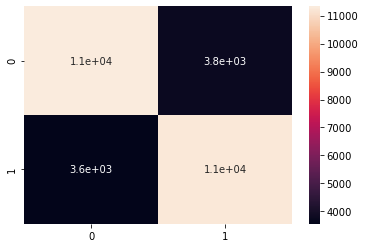

In [24]:
LR_cf_matrix = confusion_matrix(y_test, LR_pred)
sns.heatmap(LR_cf_matrix, annot=True);

## Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
DT_clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
DT_pred = DT_clf.predict(X_test)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, DT_pred))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     15129
           1       0.62      0.62      0.62     14798

    accuracy                           0.63     29927
   macro avg       0.63      0.63      0.63     29927
weighted avg       0.63      0.63      0.63     29927



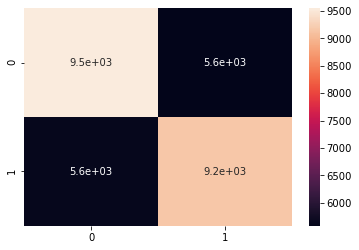

In [27]:
DT_cf_matrix = confusion_matrix(y_test, DT_pred)
sns.heatmap(DT_cf_matrix, annot=True);

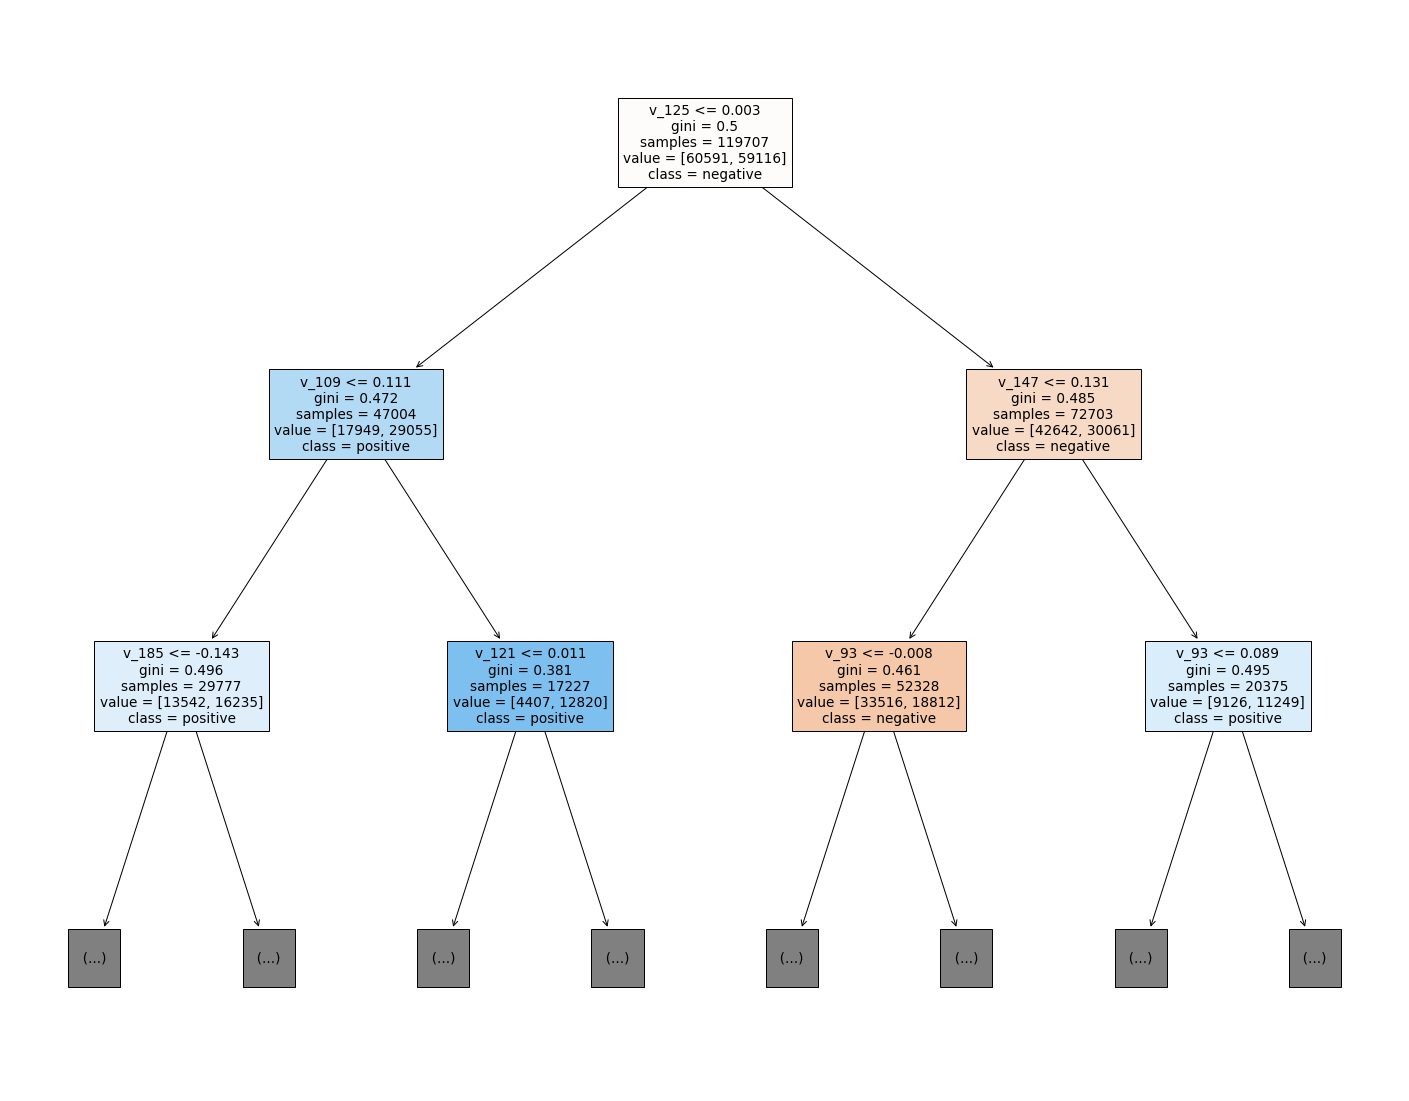

In [28]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
plot_tree(DT_clf, max_depth=2, feature_names=X_test.columns, class_names=["negative", "positive"], filled=True);

## Naive Bayes

In [29]:
from sklearn.naive_bayes import GaussianNB
NV_clf = GaussianNB().fit(X_train, y_train)
NV_pred = NV_clf.predict(X_test)

In [30]:
print(classification_report(y_test, NV_pred))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71     15129
           1       0.71      0.60      0.65     14798

    accuracy                           0.68     29927
   macro avg       0.69      0.68      0.68     29927
weighted avg       0.69      0.68      0.68     29927



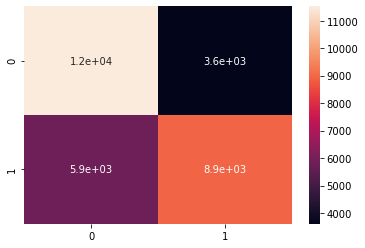

In [31]:
NV_cf_matrix = confusion_matrix(y_test, NV_pred)
sns.heatmap(NV_cf_matrix, annot=True);

## Neural Network with validation set

This Neural network uses 10% of the traning data as validation set, and it terminates the trainging when validation score is not improving by at least 
1e-5 for 10 consecutive iterations

In [32]:
from sklearn.neural_network import MLPClassifier


In [33]:
NN_clf_stop = MLPClassifier(random_state=1, max_iter=30, hidden_layer_sizes=(16,16), tol=1e-5, early_stopping=True, learning_rate_init=0.01)
NN_clf_stop.fit(X_train, y_train)
NN_pred_stop = NN_clf_stop.predict(X_test)

In [34]:
print(classification_report(y_test, NN_pred_stop))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     15129
           1       0.76      0.76      0.76     14798

    accuracy                           0.76     29927
   macro avg       0.76      0.76      0.76     29927
weighted avg       0.76      0.76      0.76     29927



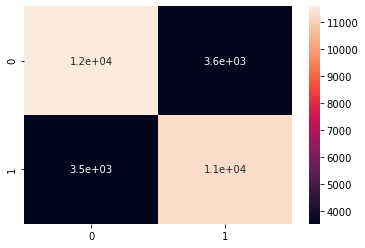

In [35]:
NN_cf_matrix_stop = confusion_matrix(y_test, NN_pred_stop)
sns.heatmap(NN_cf_matrix_stop, annot=True);

In [36]:
print("The number of iterations done is ", NN_clf_stop.n_iter_)

The number of iterations done is  24


## Stochastic Gradient Descent Linear SVM 

In [37]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [38]:
SGD_SVM_clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=500, tol=1e-3))

In [39]:
SGD_SVM_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(max_iter=500))])

In [40]:
SGD_SVM_pred = SGD_SVM_clf.predict(X_test)

In [41]:
print(classification_report(y_test, SGD_SVM_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75     15129
           1       0.75      0.72      0.73     14798

    accuracy                           0.74     29927
   macro avg       0.74      0.74      0.74     29927
weighted avg       0.74      0.74      0.74     29927



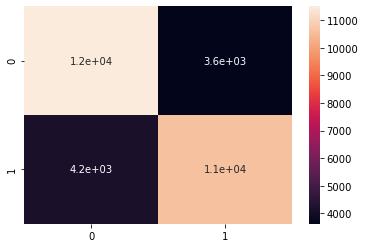

In [42]:
SGD_SVM_cf_matrix = confusion_matrix(y_test, SGD_SVM_pred)
sns.heatmap(SGD_SVM_cf_matrix, annot=True);